Возьмите базу трафика с сайта компании. Напишите модель для прогнозирования трафика. 

Возьмите xLen = 60. Добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [ ]:
!pip install OpenBlender

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical 
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
# Free Spoken Digit Dataset

# Подготовка данных

In [ ]:
import OpenBlender
from io import StringIO
import pandas as pd
import json


action = 'API_getObservationsFromDataset'

# ANCHOR: 'Bitcoin vs USD'

        
parameters = { 
    	'token':'62454a979516292a654c6d17K0JYvGhQXfqRjiDCI8zKinpXIdmV1u',
	'id_user':'62454a979516292a654c6d17',
	'id_dataset':'5d4c3af79516290b01c83f51' 
}
        

data = pd.read_json(StringIO(json.dumps(OpenBlender.call(action, parameters)['sample'])), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
data.reset_index(drop=True, inplace=True)
data.head()

Task ID: '624569210895fafb4a9d8d4b'.
Total estimated consumption: 500.28 processing units.
20.0 %
40.0 %
60.0 %
80.0 %
100.0 % completed.


,volume,timestamp,price,high,low,open,change
0,2.75K,1.629652e+09,49264.0,49487.0,48121.0,48868.0,0.81%
1,21.16K,1.620925e+09,49747.0,51154.0,48120.6,49725.0,0.04%
2,14.96K,1.620839e+09,49725.0,57688.0,49725.0,56715.0,-12.32%
3,7.69K,1.620752e+09,56715.0,56724.0,54789.0,55851.0,1.55%
4,13.49K,1.620666e+09,55851.0,59454.3,55448.0,58276.0,-4.16%


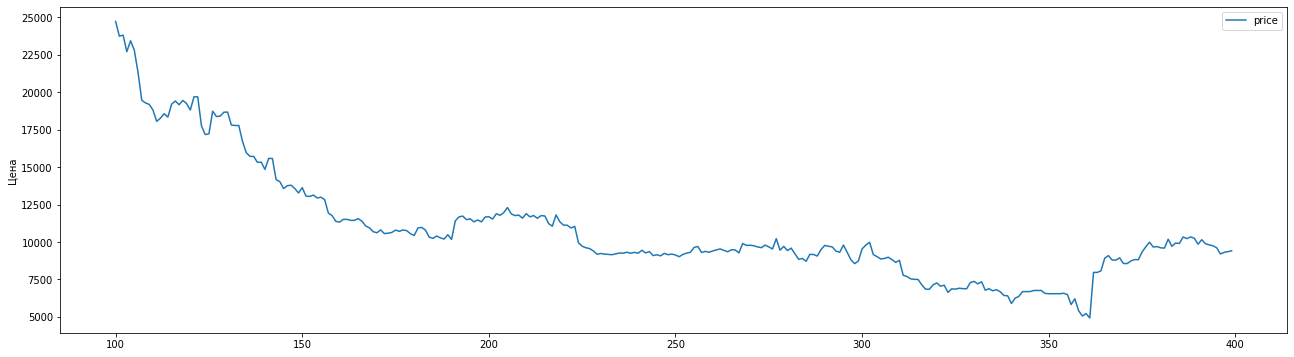

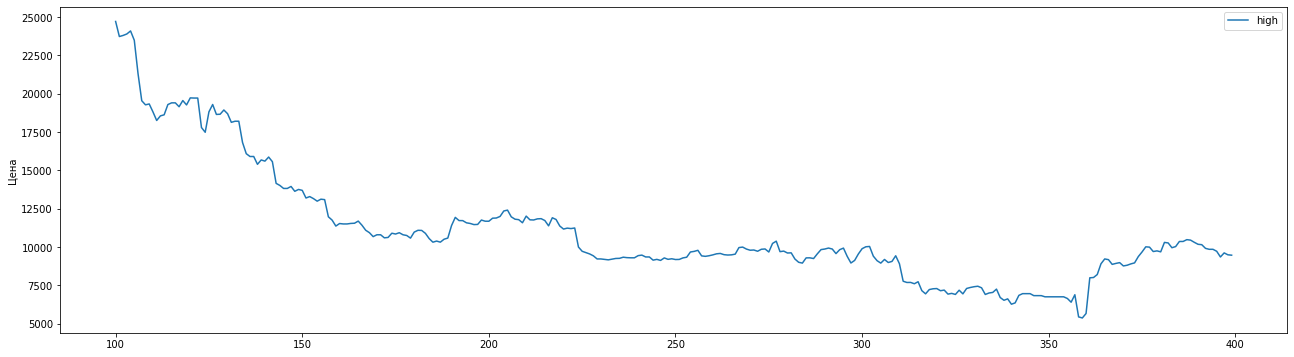

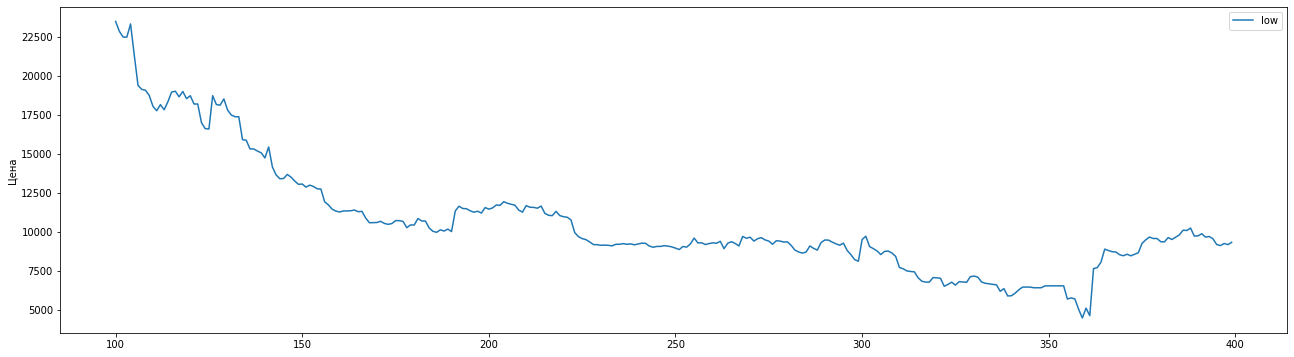

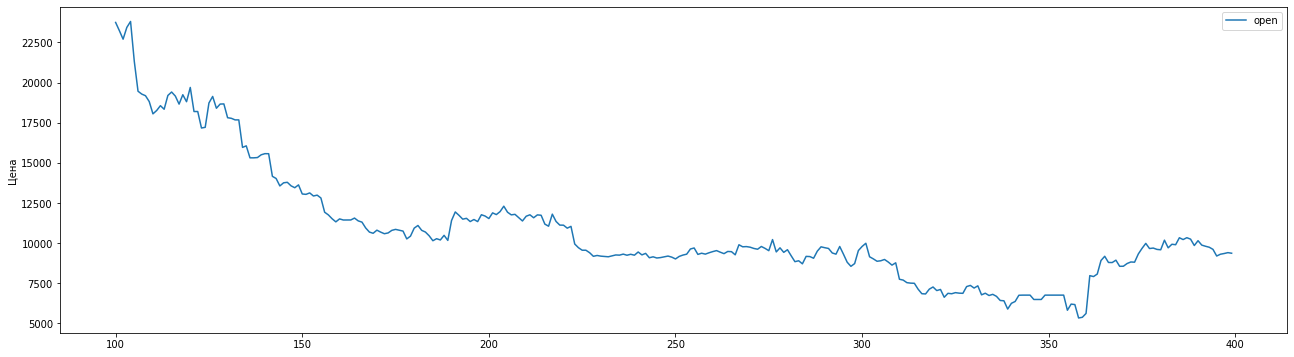

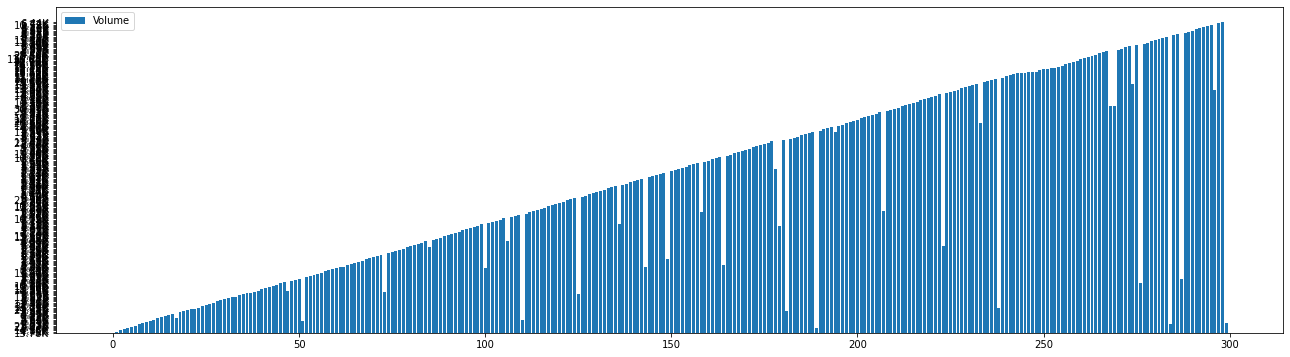

In [ ]:
start = 100
length = 300

chanelNames = ['price', 'high', 'low', 'open']

for ii in range(len(chanelNames)):
  plt.figure(figsize=(22,6))
  plt.plot(data[chanelNames[ii]][start:start+length], 
            label=chanelNames[ii])
  plt.ylabel('Цена')
  plt.legend()
  plt.show()

plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data["volume"][start:start+length], label="Volume")
plt.legend()
plt.show()

# Вспомогательные функции

## Предсказание и вывод в начальном виде

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predict_y = currModel.predict(xVal)
  predVal = yScaler.inverse_transform(predict_y)
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

## Таблица ошибки при обучении

In [ ]:
def show_loss(history):
  plt.figure(figsize=(14,7))
  plt.plot(history.history['loss'], 
          label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Средняя абсолютная ошибка на проверочном наборе')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

## Проверка корреляции данных

In [ ]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa != 0) & (sb != 0)):
    val = (mab-ma*mb) / (sa*sb)

  return val

## Вывод корреляции

In [ ]:
def showCorr(channels, corrSteps, predVal, yValUnscaled):

  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):

      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = []

     
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+10) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

## График предсказанного и реального

In [ ]:
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

## Создание полносвязной модели

In [ ]:
def create_dense_model(xLen=60, steps=1):
  modelD = Sequential()
  modelD.add(Dense(200, input_shape = (xLen, 1), activation="relu" ))
  # modelD.add(Dense(100, activation="relu" ))
  modelD.add(Flatten())
  modelD.add(Dense(steps, activation="linear"))

  modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

  modelD.summary()

  return modelD

## Получение данных

In [ ]:
def get_data(data, xLen=60, valLen=300):

  trainLen = len(data) - valLen
  trainLen = len(data[:trainLen])
  testLen = len(data[trainLen + xLen:-xLen])

  xTrain = data[:trainLen].reshape(trainLen, 1)
  xTest = data[trainLen + xLen: -xLen].reshape(testLen, 1)

  yTrain = np.reshape(data[xLen:trainLen + xLen], (-1, 1))
  yTest = np.reshape(data[trainLen + xLen * 2:], (-1, 1))

  xScaler = MinMaxScaler()
  xScaler.fit(xTrain)

  yScaler = MinMaxScaler()
  yScaler.fit(yTrain)

  xTrain = xScaler.transform(xTrain)
  xTest = xScaler.transform(xTest)
  
  yTrain = yScaler.transform(yTrain)
  yTest = yScaler.transform(yTest)

  trainDataGen = TimeseriesGenerator(xTrain, yTrain, 
                                length=xLen, stride=1, sampling_rate=1,
                                batch_size=20)


  testDataGen = TimeseriesGenerator(xTest, yTest,
                                length=xLen, stride=1,
                                batch_size=20)
    
   
  DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen,
                               batch_size=len(xTest))
  xVal = []
  yVal = []
  for i in DataGen:
    xVal.append(i[0])
    yVal.append(i[1])

  xVal = np.array(xVal)
  yVal = np.array(yVal)
    


  return [trainDataGen, testDataGen, xScaler, yScaler, xVal, yVal]


In [ ]:
print(data.shape)

(2811, 7)


In [ ]:
np.array(data["open"])

array([4.8868e+04, 4.9725e+04, 5.6715e+04, ..., 1.3400e+01, 1.3300e+01,
       1.3300e+01])

In [ ]:
new_data = get_data(np.array(data["open"]))
trainDataGen, testDataGen = new_data[0], new_data[1]
xScaler, yScaler = new_data[2], new_data[3]
xVal, yVal = new_data[4], new_data[5]

## Подготовка модели

In [ ]:
# create new model
model = create_dense_model(xLen=60)

# learning model
history = model.fit(
                    trainDataGen, 
                    epochs=10, 
                    verbose=1, 
                    validation_data = testDataGen, 
                    )

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 60, 200)           400       
                                                                 
 flatten_12 (Flatten)        (None, 12000)             0         
                                                                 
 dense_29 (Dense)            (None, 1)                 12001     
                                                                 
Total params: 12,401
Trainable params: 12,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
123/123 [==============================] - 3s 11ms/step - loss: 0.0055 - val_loss: 4.1736e-04
Epoch 2/10
123/123 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 7.5984e-04
Epoch 3/10
123/123 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 6.7436e-04


## График ошибок

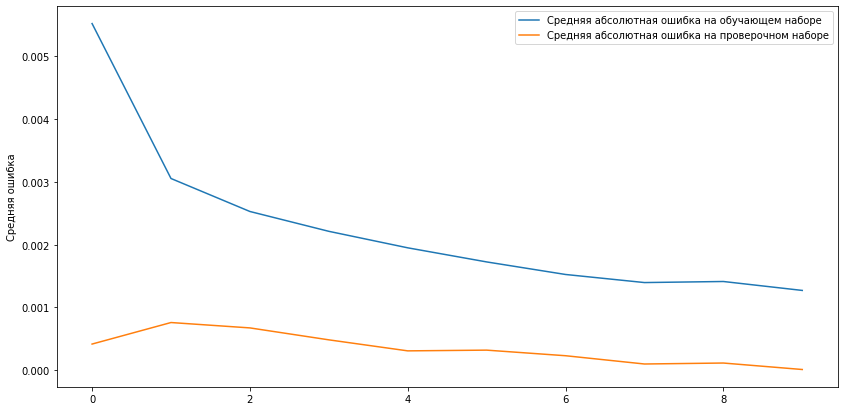

In [ ]:
show_loss(history)

## Предсказанные данные

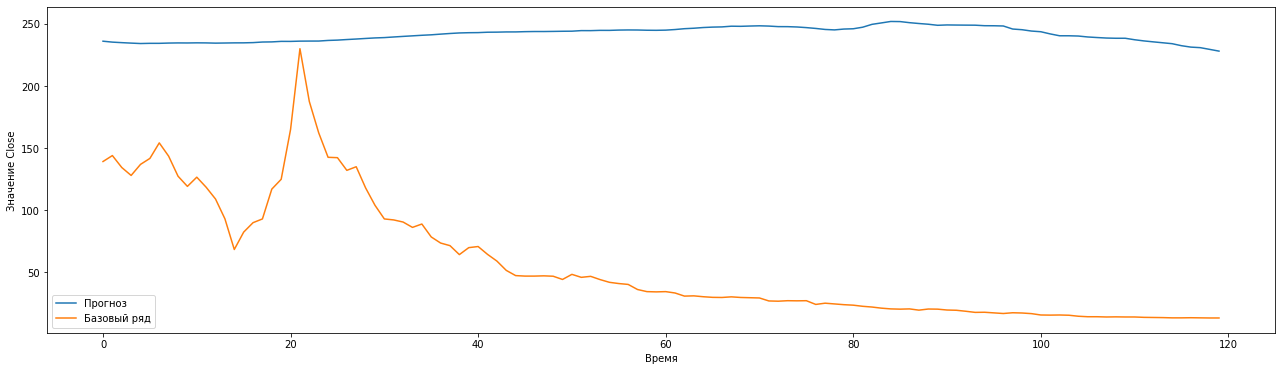

In [ ]:
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 160, 0, predVal, yValUnscaled)

## Корреляция данных

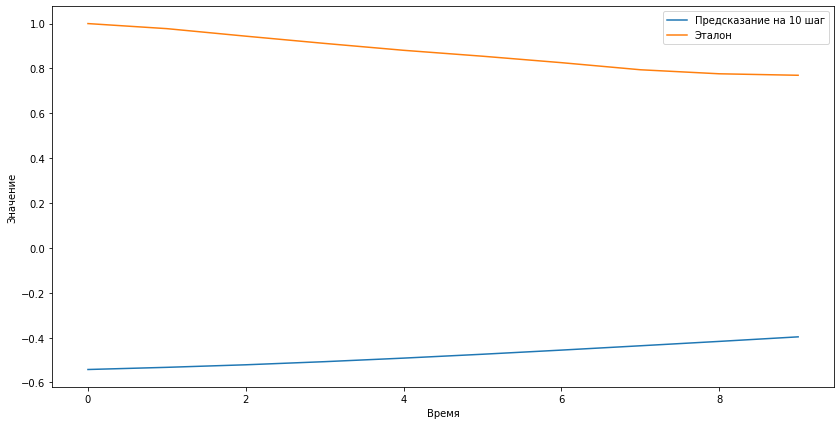

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)